# Appendix E Sampling Distribution 

## E.1 Sampling from the true population

Most properties in statistics describe the behaviour of a procedure under repeated sampling from the true population. The problem is, in the real world, the true population is unknown. In a synthetic environment (e.g., simulation in Appendix D), we do know the true population as well as the sampling scheme. 

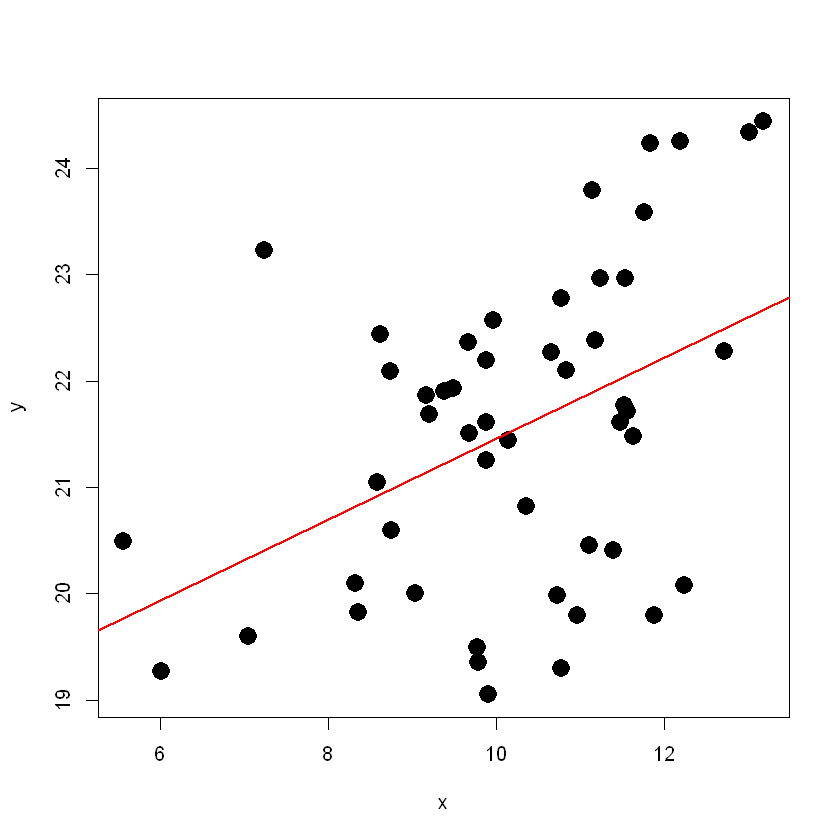

In [3]:
### To match our setup, we will generate the covarates and keep them fixed in the remainder of the simulation. 
set.seed(1)
n=50;
x=as.matrix(rnorm(n,mean=10,sd=2),ncol=n);
beta.true=c(20,0.15)
Ey= x*beta.true[2]+beta.true[1];

error.terms= (runif(n)-0.5)*5;
y=Ey+error.terms;
beta.hat=lm(y~x)$coef;


plot(x=x,y=y,pch=16,cex=2)
abline(b=beta.hat[2],a=beta.hat[1],col='red',lwd=2)

In [4]:
### Write a function:
simulate.one.instance<-function(x,beta.true){
  n=length(x);
  Ey= x*beta.true[2]+beta.true[1];
  error.terms= (runif(n)-0.5)*5;
  y=Ey+error.terms;
  beta.hat=lm(y~x)$coef;
  return(beta.hat)
}


In [5]:
### Set the number of replicates to be 10000
N.sim=1e4;
set.seed(1)
n=50;
x=as.matrix(rnorm(n,mean=10,sd=2),ncol=n);
beta.true=c(20,0.15)
beta.sim=replicate(N.sim,simulate.one.instance(x,beta.true));

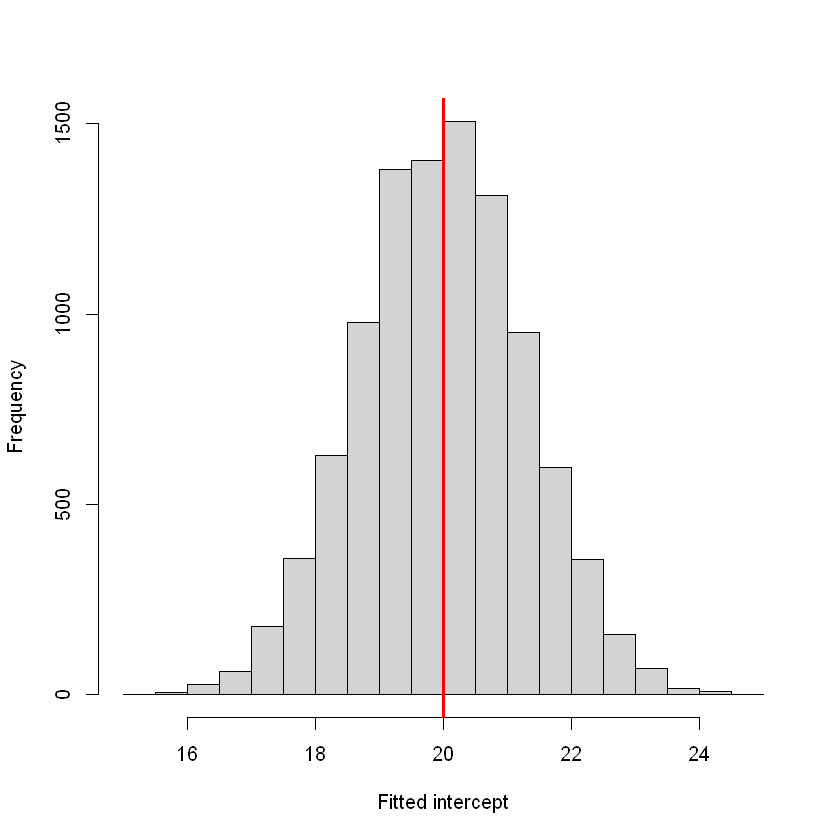

In [9]:
# Draw the histogram for the estimated intercept 
hist(beta.sim[1,],xlab='Fitted intercept',main='')
abline(v=beta.true[1],lwd=3,col='red')

In [11]:
## Using the simulation results, we can verify a few results from linear regression:

### Expectation 
mean(beta.sim[1,])-beta.true[1] # intercept 
mean(beta.sim[2,])-beta.true[2] # slope 

### Variance 
sigma.sq = 5^2/12; # variance of the error: (runif(n)-0.5)*5;

# slope:
sigma.sq/sum(  (x-mean(x))^2  ) # theoretical value 
var(beta.sim[2,]) # variance from the simulation 


# intercept:
sigma.sq*sum(x^2)/sum(  (x-mean(x))^2  )/n # theoretical value 
var(beta.sim[1,]) # variance from the simulation 

[1] -0.02057678

[1] 0.001874243

[1] 0.01537762

[1] 0.01562145

[1] 1.641835

[1] 1.669428

## E.2 Sampling from observed samples

In most case, the true population or true data generating mechanisms are unknown. As a work-around, we can make full use of the observed samples to *approximate* the true population. This approximation is *exact* only when the samples exhaust the true population (e.g., a mandatory survey in a class). In most cases, it remains an approximation.


### E.2.1 Bootstrap 

There are two factors that affect the sampling distribution for any estimator: (i) the true population and (ii) the sampling scheme. Boostrap is based on a simple idea of treating the observed samples as the true population. In bootstrap, (i) the observed samples are seen as the true population, and (ii) a sampling scheme is chosen to micmic the true mechanism. To be specific, if the samples are i.i.d. (independently and identically distributed), the bootstrap procedure will draw samples with replacement with equal probability from the observed samples, where "with replacement" is because of independence and "equal probability" if because of identical distribution. The bootstrap sampling distribution approximates the true sampling distribution when the sample size is large. 

There are many variants of bootstrap (see, e.g., [here](https://en.wikipedia.org/wiki/Bootstrapping_populations)). We will examine the nonparametric bootstrap in this section. 

We will revist the confidence interval in Appendix D.3. This time we write our own bootstrap function to construct the confidence interval. It is important to note the similarity between the `simulate.one.instance` function in Appendix D.3 and the `boot.fit` function below. 

In practice, we use the `boot` function in the package `boot` for bootstrapping. 


In [11]:
set.seed(1)
n=50;
x=as.matrix(rnorm(n,mean=10,sd=2),ncol=n);
beta.true=c(20,0.15)
Ey= x*beta.true[2]+beta.true[1];
error.terms= rnorm(n)*5;
y=Ey+error.terms;

alpha=0.05

In [17]:
# How does the bootstrap function differ from the simulation function?
# 
boot.fit<-function(covariate,outcome){
  n=length(outcome);
    
  sample_indices = sample(1:n,n,replace=TRUE) # sampling with replacement
  
    # Sample covariates (x), or not?
  covariate.boot= covariate[sample_indices]; 
  outcome.boot= outcome[sample_indices];
   
  
  beta.hat=lm(outcome.boot~covariate.boot)$coef;
  return(beta.hat)
}
B=5e4;
beta.hat.boot=replicate(B,boot.fit(covariate=x,outcome=y));


In [20]:
t(apply(beta.hat.boot,1,quantile,probs=c(0.025,0.975)))

,2.5%,97.5%
(Intercept),13.6282133,30.9888299
covariate.boot,-0.8696521,0.8588346


In [16]:
confint(lm(y~x+1),alpha=0.05)

,2.5 %,97.5 %
(Intercept),13.0188972,30.4775452
x,-0.8086838,0.8809413


### E.2.2 Permutation 

In hypothesis testing, the test statistic is compared to the *null distribution*, that is the *sampling distribution under the null hypothesis*. Sometimes the null hypothesis is specific enough that we can approximate the true distribution using the observed samples. 

Suppose that we observe $n$ i.i.d. samples $\{ (x_1,y_1), (x_2,y_2), \ldots, (x_n,y_n)\}$ from an unknown true population. For instance, we can imagine that $x$ is the face of a coin (Head, Tail) and $y$ is the age of the tosser. We are interested in the following hypothesis
$$
H_0: \mathbb{E}[y \mid x ={\rm Tail}] = \mathbb{E}[y \mid x ={\rm Head}]
$$
$$
H_1: \mathbb{E}[y \mid x ={\rm Tail}] \neq  \mathbb{E}[y \mid x = {\rm Head}].
$$
Under the null, we know that the expectation of $y$ remains the same regardless of the value of $x$. This means that the the expectation of $y$ should remain the same if we shuffle $x$, e.g., by creating a new data set as 
$$
\{ (x_6,y_1), (x_{17},y_2), \ldots, (x_3,y_n)\},
$$
where the indices of $x$s are *permuted*. From the permuted data set, we can estimate the mean difference between two groups defined by the new $x$.  

In [32]:
set.seed(1)
n=50;
x=rbinom(n=50,size=1,prob=0.5)
mu.diff=1; 
error.terms= rnorm(n)*2; # Normal errors
y=x*mu.diff+error.terms;

diff=mean(y[x==1])-mean(y[x==0])

In [33]:
x.perm=sample(x,size=length(x),replace=FALSE);

(mean.diff=mean(y[x.perm==1])-mean(y[x.perm==0]))


[1] -0.9403222

In [34]:
## Permutation + mean diff
permutation.diff<-function(x,y){
  n=length(y);
  x.perm=sample(x,size=length(x),replace=FALSE);
  mean.diff=mean(y[x.perm==1])-mean(y[x.perm==0])
  return(mean.diff)
}

In [42]:
set.seed(1)
n=50;
x=rbinom(n=50,size=1,prob=0.5)
mu.diff=4; 
error.terms= rnorm(n)*2; # Normal errors
y=x*mu.diff+error.terms;

diff=mean(y[x==1])-mean(y[x==0])


mean.diff.perm=replicate(1e5,permutation.diff(x,y));

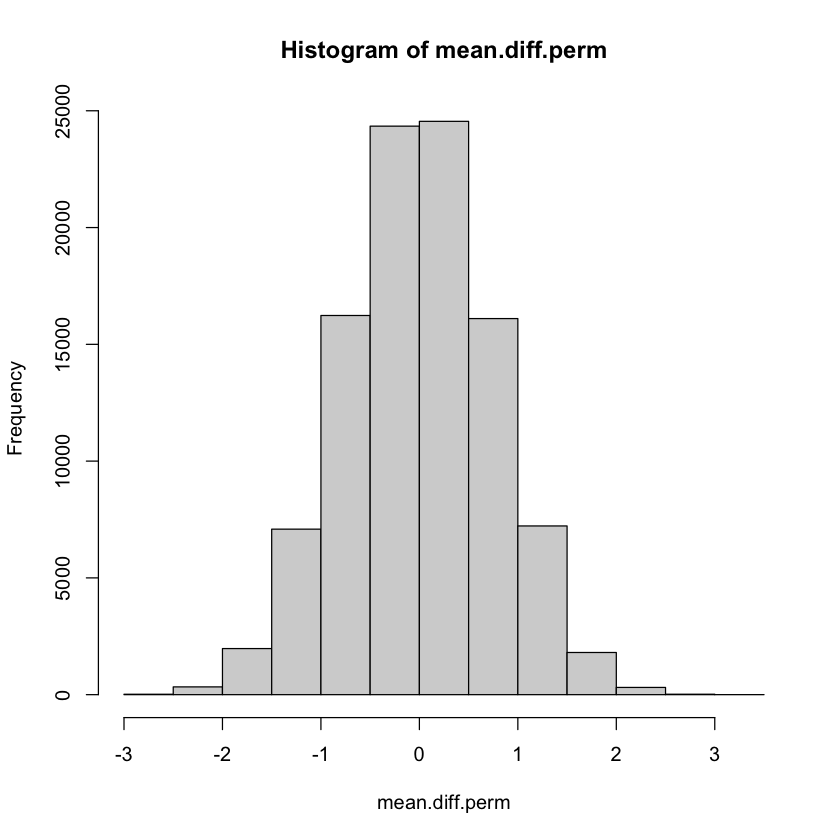

In [43]:
hist(mean.diff.perm)

In [44]:
1-mean(abs(diff) > abs(mean.diff.perm))

[1] 0